In [1]:
from geecs_python_api.controls.interface import load_config
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
from geecs_python_api.controls.interface.geecs_errors import ErrorAPI
from geecs_python_api.controls.data_acquisition import ScanManager, SoundPlayer, DataInterface
from geecs_python_api.controls.data_acquisition import visa_config_generator
from geecs_python_api.controls.data_acquisition.scan_analysis import CameraImageAnalysis
from image_analysis.utils import read_imaq_png_image, extract_shot_number

import os
import yaml
import pandas as pd
import shelve
import sys

import time
import numpy as np

from image_analysis.labview_adapters import analyze_labview_image
from pathlib import Path


path config ../../../../user data/Configurations.INI
database name  loasis
default experiment is: Undulator


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# set up the python objects for the geecs devices to be used in optimization
s3h = GeecsDevice('U_S3H')
s4h = GeecsDevice('U_S4H')

# define a dict containing the specific variables and bounds to be used in optimization
objs={'S3H':{"GEECS_Object":s3h,'variable':"Current","bounds":[-2,2]},
    'S4H':{"GEECS_Object":s4h,'variable':"Current","bounds":[-2,2]}}

In [71]:
#define whether or not to use normalized values and ranges for optimization controls. 
#Normalization seems like a good idea
normalize=False

#for opt method, choose nelder or bayes for now
opt_method='bayes'

#define the xopt configuration
YAML = """
generator:
    name: upper_confidence_bound
    beta: 2
evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
        {}
    objectives: {f: "MAXIMIZE"}

"""
yaml_output = yaml.safe_load(YAML)

In [47]:
def geecs_measurement(input_dict):
    for i in list(input_dict.keys()):
        set_val=float(input_dict[i])
        print('set '+str(i)+' to '+str(set_val))
        #line below executes the set commands.
        objs[i]["GEECS_Object"].set(objs[i]["variable"],set_val)
        time.sleep(0)
        
    setpoint=input_dict
    print(setpoint)
    
    value=calcTransmission(setpoint)

    return {'f': value}

In [70]:

from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

yaml_string = yaml.dump(yaml_output)
X = Xopt.from_yaml(yaml_string)
X.generator.gp_constructor.use_low_noise_prior = false


            Xopt
________________________________
Version: 2.0.1
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.geecs_measurement
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    f: MAXIMIZE
  observables: []
  variables:
    S3H:
    - -2.0
    - 2.0
    S4H:
    - -2.0
    - 2.0


In [7]:
# Example usage for DataLogger
experiment_dir = 'Undulator'
shot_control_device = 'U_DG645_ShotControl'
scan_manager = ScanManager(experiment_dir=experiment_dir, shot_control_device = shot_control_device)

file1 = 'HiResOnly.yaml'

scan_manager.reinitialize(file1)

In [3]:
#test scan for a composite variable scan below, combined with using the reinitialize method
scan_config = {'device_var': 'noscan', 'start': -1, 'end': 1, 'step': 2, 'wait_time': 105.5, 'additional_description':'Testing out new python data acquisition module'}
# scan_manager.start_scan_thread(scan_config=scan_config)

In [8]:
# Start the scan thread
scan_manager.start_scan_thread(scan_config=scan_config)
scan_manager.pause_scan()

In [9]:
# Initialize shot tracking variables
dev_name = 'UC_HiResMagCam'
data_path = scan_manager.data_interface.local_scan_dir_base / scan_manager.data_interface.next_scan_folder

def get_new_files(data_path, last_shot_number):
    """Retrieve new files based on shot numbers."""
    new_files = []
    for file in data_path.glob(f"{dev_name}*"):  # Modify pattern as needed
        # Convert file to string and extract shot number
        shot_number = extract_shot_number(str(file))  # Adjust splitting logic if needed
        if shot_number > last_shot_number:
            new_files.append((shot_number, file))
    return sorted(new_files, key=lambda x: x[0])  # Sort by shot number for orderly processing

def avg_images(files):
    """
    Load all images and average them.

    Args:
        list of file paths of Imaq png images

    Returns:
        average of the images in uint16.
    """
    images = []

    for file in files:
        # print(f'file: {file}')
        image = read_imaq_png_image(file[1])
        images.append(image)

    return np.mean(images, axis=0).astype(np.uint16)  # Keep 16-bit format for the averaged image
 
collection_time = 5
last_shot_number = 0  # Keep track of the last shot number

# Loop to handle scan cycles and file processing
for i in range(10):
    # Resume scan
    scan_manager.resume_scan()
    time.sleep(collection_time)
    scan_manager.pause_scan()

    # Retrieve and process new files
    new_files = get_new_files(data_path / dev_name, last_shot_number)
    avg_image = avg_images(new_files)

    res = analyze_labview_image(dev_name, avg_image, None)
    print(f'res: {res[1]}')
    # Update last shot number for the next iteration
    if new_files:
        last_shot_number = new_files[-1][0]  # Last shot number processed
    
    scan_manager.data_logger.bin_num += 1

scan_manager.resume_scan()
scan_manager.stop_scanning_thread()


In [10]:
# #test scan for a composite variable scan below, combined with using the reinitialize method
# scan_config = {'device_var': 'ALine_e_beam_position_offset_x', 'start': -1, 'end': 1, 'step': 2, 'wait_time': 105.5, 'additional_description':'Testing out new python data acquisition module'}
# scan_manager.reinitialize(file1)
# scan_manager.start_scan_thread(scan_config=scan_config)

In [6]:
# device_type = 'UC_HiResMagCam'
# img = read_imaq_png_image(Path('Scan021_UC_HiResMagCam_006.png'))
# res = analyze_labview_image(device_type, img, None)
# res[1]

In [73]:
from geecs_python_api.controls.interface import load_config
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
from geecs_python_api.controls.interface.geecs_errors import ErrorAPI
from geecs_python_api.controls.data_acquisition import ScanManager, SoundPlayer, DataInterface
from geecs_python_api.controls.data_acquisition import visa_config_generator
from geecs_python_api.controls.data_acquisition.scan_analysis import CameraImageAnalysis

import time

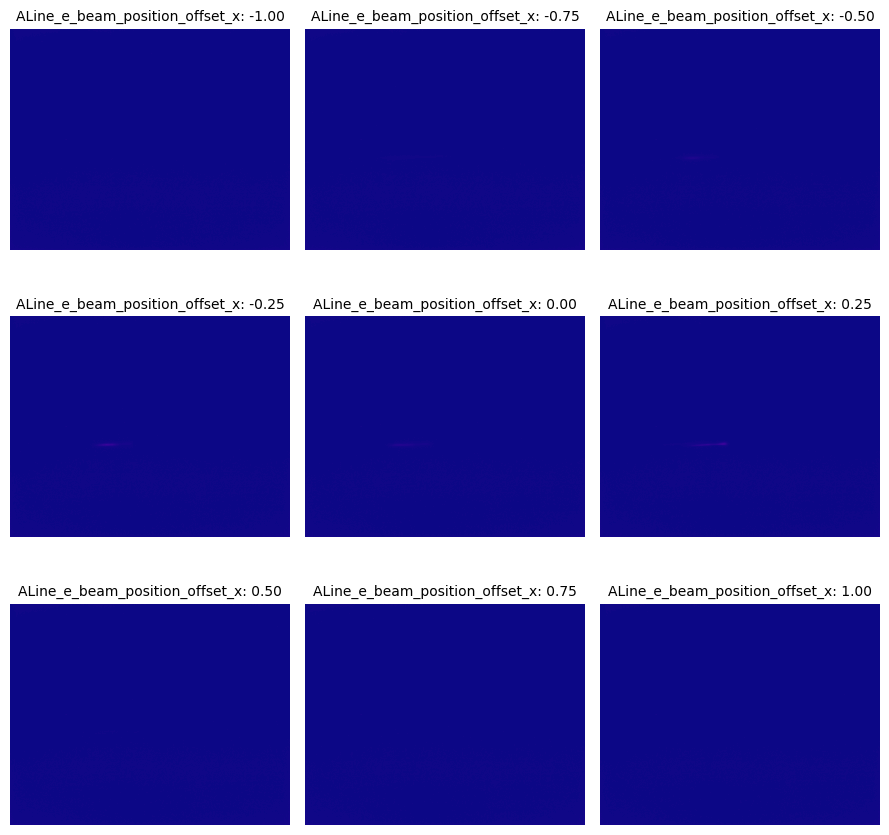

In [77]:

experiment_dir = 'Undulator'

d_interface = DataInterface()

d_interface.local_scan_dir_base
d_interface.reset_date('2024','Oct', '31')
d_path = (d_interface.create_data_path(30))[0] / 'Scan038'

scan_dir = d_path
data_subdir = 'UC_VisaEBeam1'
data_subdir = 'UC_UndulatorRad2'

analysis = CameraImageAnalysis(scan_dir, data_subdir,use_gui=False)
analysis.run_analysis()